### Camera Calibration

In [1]:
# Declare required libraries
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip


%matplotlib inline

In [2]:
# function to just find chessboard corners only of an image passed in
def chessboard_corners(img, nx=9, ny=6):
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # create array to store found corners
    image_points = []
    # create intance of image in grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners in the image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found all points for the nx,ny grid size are found - then add them into arrays
    if ret == True:
            # once corners are found increase accuracy of corner position
            corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),criteria)
            # append the 2D image points into 2D points array
            #image_points.append(corners2)
            # return found corners in array
            return corners2
    
    


In [3]:
# Function to return 2 arrays (2D points and 3D points) of grid corners for each image in a folder location
def chessboard_points(nx=9, ny=6):
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Create arrays to store object points and image points from the images.
    object_points = [] # 3d points in real world space
    image_points = [] # 2d points in image plane.
    
    # read in all images from the folder location
    images = glob.glob('./camera_cal/*.jpg')

    # image processing counters
    num_images, images_used = 0, 0
    
    # loop through all images stored in images array
    for fname in images:
        # read in am image
        img = cv2.imread(fname)
        
        # count image as total of set
        num_images += 1
        
        # create intance of image in grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # get original image size - both methods produce same result
        img_size = gray.shape[::-1]
        #img_size = (img.shape[1], img.shape[0])

        # Find the chessboard corners in the image
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found all points for the nx,ny grid size are found - then add them into arrays
        if ret == True:
            
            images_used += 1
            # once corners are found increase accuracy of corner position
            corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),criteria)
            # append the 2D image points into 2D points array
            image_points.append(corners2)
            # append a 3D grid into 3D points array
            object_points.append(objp)
    
    # message to show number of images processed during find corners
    print("{0} out of {1} images had sucessful corner detection".format(num_images,images_used))
    
    return object_points, image_points, img_size

In [4]:
# Function to generate camera calibration and store it in calibration file
# generates the camera matrix, distortion coefficients, rotation and translation vectors
def generate_calibration(img_size, object_points, image_points):

    # calibrate camera image based on 2D points, and fit into 3D array
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size, None, None)
    
    # Create pickled calibration file
    # create a variable to hold calibration data
    calibration_parameters = {}
    # add matrix and distortion parameters
    calibration_parameters['mtx'] = mtx
    calibration_parameters['dist'] = dist
    # pickle the calibration data - write bytes
    pickle.dump(calibration_parameters, open('./camera_calibration.p', 'wb'))
    
    # does not return anything as pickled file is output of function

In [5]:
# Function to open pickled calibration data

def get_calibration():
    # Read in the saved camera matrix and distortion coefficients - read bytes
    ret_calib = pickle.load(open('./camera_calibration.p', 'rb'))
    # assign unpickled data to variables
    mtx = ret_calib['mtx']
    dist = ret_calib['dist']
    # return unpickled data - matix & distortion parameters
    return mtx, dist


In [6]:
# Function to correct a passed in image from stored calibration data

def image_correct(img):
    
    # retrieve the camera calibration from a pickled file
    mtx, dist = get_calibration()
    # undistort image with paramters received from calibration
    corrected_image = cv2.undistort(img, mtx, dist, None, mtx)
    # return corrected image
    return corrected_image
    

In [7]:
# pipeline to obtain a camera calibration from a number of checkerboard images

# get image points arrays - object_points = 3D; image_points = 2D + image_size
object_points, image_points, image_size = chessboard_points()
# generate the camera calibration data - this gets stored into a pickled file
generate_calibration(image_size, object_points, image_points)


20 out of 17 images had sucessful corner detection


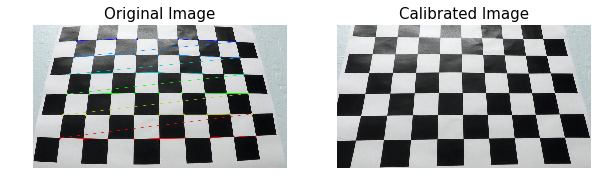

In [14]:
# Test Camera Calibration on sample image

# specify a sample image to correct for checking purposes
img = cv2.imread('./camera_cal/calibration3.jpg')
# use image_correct function to get a correct image using camera stored calibration
corrected_image = image_correct(img)

nx = 9
ny = 6

test_corners = chessboard_corners(img, nx, ny)
cv2.drawChessboardCorners(img, (nx, ny), test_corners, True)

# explicitly set figure size
fig = plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image', fontsize=15)
plt.subplot(1,2,2)
plt.imshow(corrected_image)
plt.axis('off')
plt.title('Calibrated Image', fontsize=15)

# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/distortion_corrected_image.png', bbox_inches='tight')


plt.show()


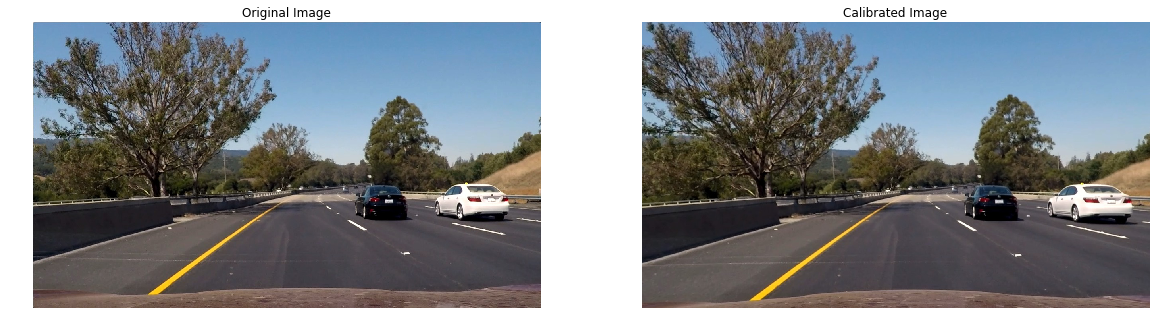

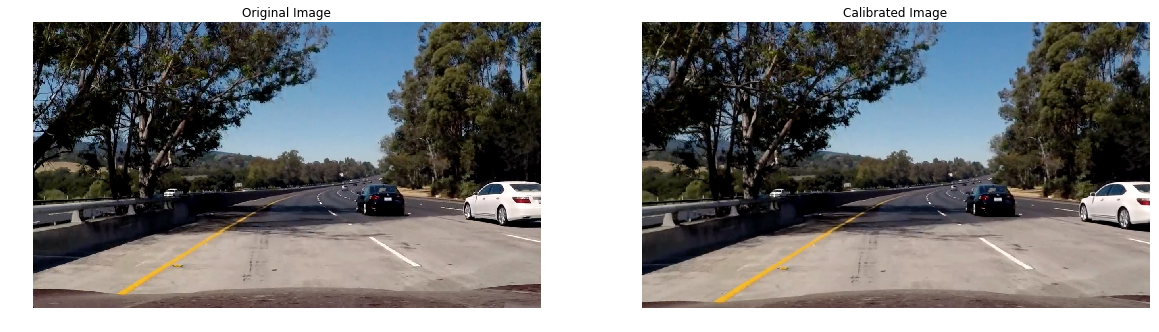

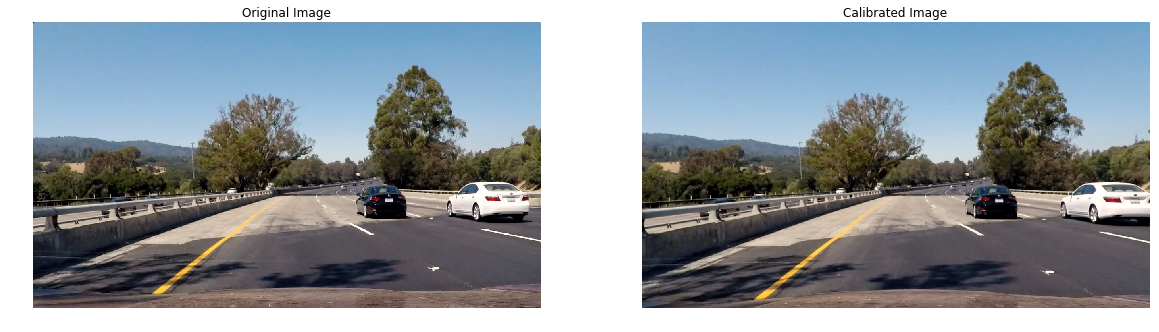

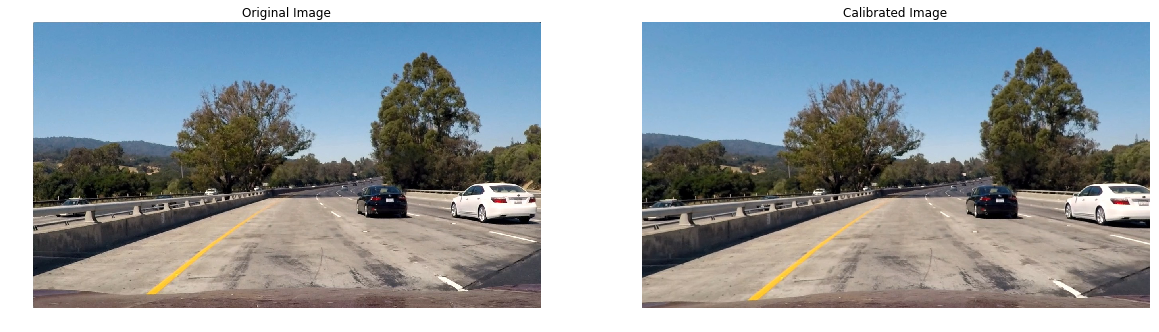

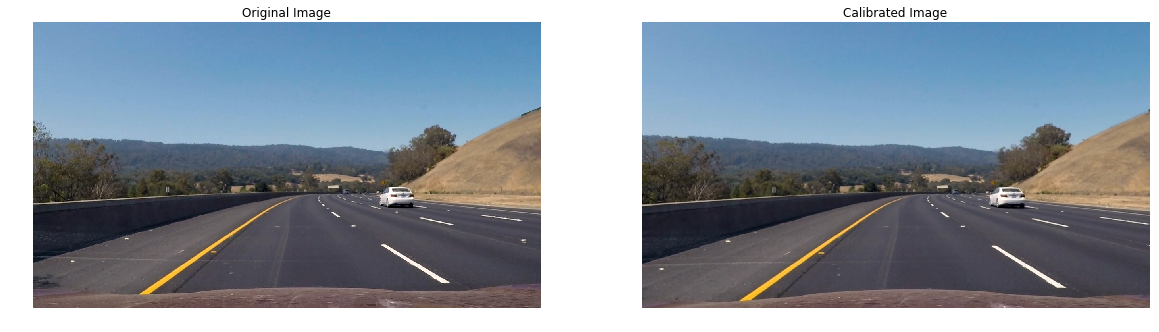

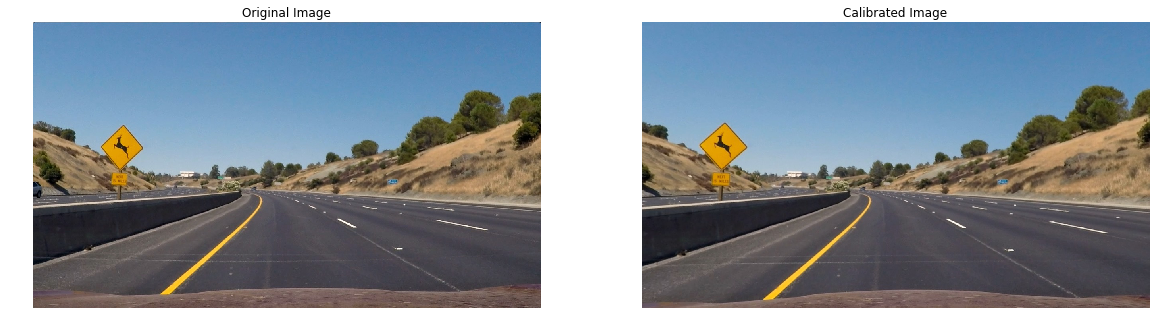

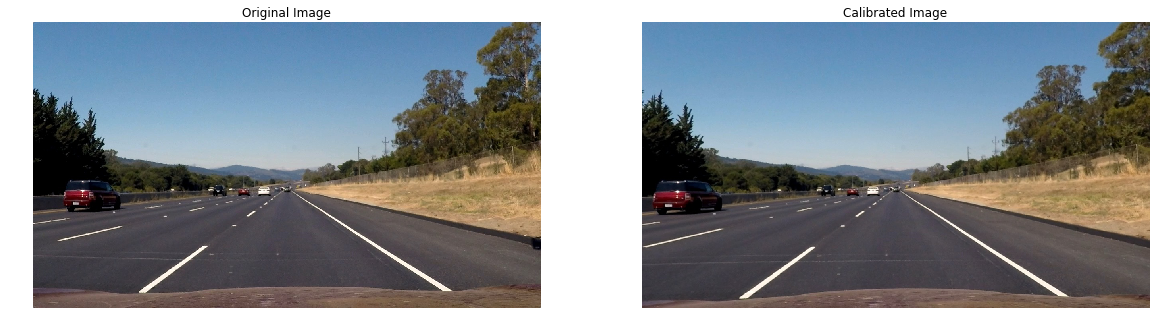

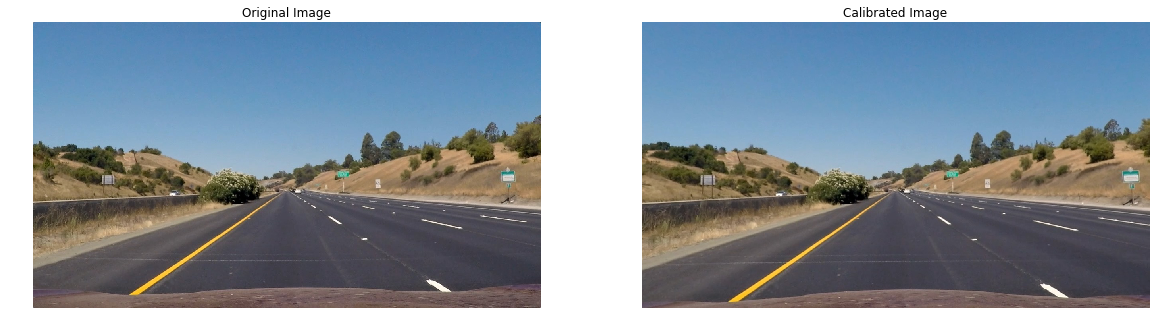

In [37]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# counter for image file naming
i = 0

for img in images:
    #create the figure
    fig = plt.figure(figsize=(20,10))
    
    # import image
    img = cv2.imread(img)
    # change image to RGB for display purpose
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # apply calibration corrections
    corrected_image = image_correct(img)
    
    ax1 = plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    
    ax1 = plt.subplot(1, 2, 2)
    plt.imshow(corrected_image)
    plt.axis('off')
    plt.title('Calibrated Image')
    
    i = i+1
    
    # fig save for report - and minimse amout of white space added to saved image
    plt.savefig('./output_images/distortion_corrected_testimages_' + str(i) + '.png', bbox_inches='tight')

    plt.show()